In [1]:
import os
from pathlib import Path
import requests
from tqdm import tqdm
from typing import Union, List

import math
import torch
import numpy as np
import audiotools as at
import dasp_pytorch
import auraloss
import laion_clap
from audiotools import AudioSignal

from transformers import BertForMaskedLM


import matplotlib.pyplot as plt
%matplotlib inline

NOTEBOOKS_DIR = Path(os.path.abspath(''))
PROJECT_DIR = NOTEBOOKS_DIR.parent
ASSETS_DIR = PROJECT_DIR / "assets"
PRETRAINED_DIR = PROJECT_DIR / "pretrained"
DATA_DIR = PROJECT_DIR / "data"

In [2]:
# Load audio examples
exts = ["mp3", "wav", "flac"]
example_files = [list(ASSETS_DIR.rglob(f"*.{e}")) for e in exts]
example_files = sum(example_files, [])  # Trick to flatten list of lists


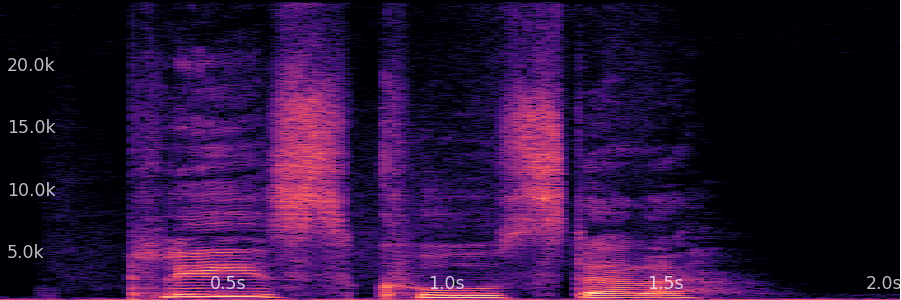
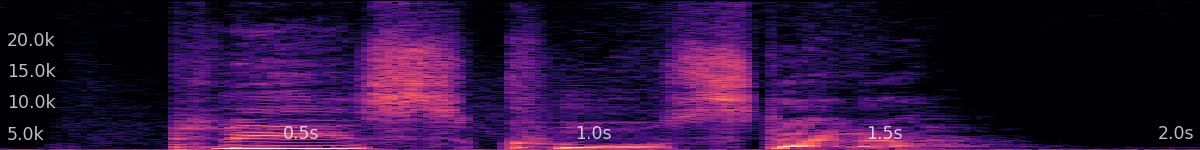

In [3]:
signal = AudioSignal(example_files[5])
signal.widget()

#### DASP set-up

In [4]:
#distortion rewrite bc of bug
class Distortion(dasp_pytorch.modules.Processor):
    def __init__(
        self,
        sample_rate: int = None,
        min_drive_db: float = 0.0,
        max_drive_db: float = 24.0,
    ):
        super().__init__()
        self.sample_rate = sample_rate
        self.process_fn = dasp_pytorch.functional.distortion
        self.param_ranges = {
            "drive_db": (min_drive_db, max_drive_db),
        }
        self.num_params = len(self.param_ranges)

In [5]:
#channel
from typing import Iterable


class Channel(torch.nn.Module):
    def __init__(self, *args):
    
        super().__init__()
    
        modules = []
        if isinstance(args[0], Iterable) and len(args) == 1:
            for m in args[0]:
                assert isinstance(m, dasp_pytorch.modules.Processor)
                modules.append(m)
        else:
            for m in args:
                assert isinstance(m, dasp_pytorch.modules.Processor)
                modules.append(m)

        # Ensure consistent sample rate
        sample_rates = [m.sample_rate for m in modules]

        # If not uniform, go with highest sample rate
        self.sample_rate = max(sample_rates)

        for i, m in enumerate(modules):
            modules[i].sample_rate = self.sample_rate
        self.modules = modules

    @property #AC what does this do? -- hacky thing decorator/annotator, concrete attribute, this is a getter
    def num_params(self):
        return sum([m.num_params for m in self.modules])

    #if you call the object, it automatically calls **forward()** (uses __call__)
    def forward(self, signal: AudioSignal, params: torch.Tensor):

        output = signal.clone().resample(self.sample_rate)
        
        # Check for valid shape
        assert params.ndim == 2  # (n_batch, n_parameters)
        assert params.shape[-1] == self.num_params

        params_count = 0
        for m in self.modules:

            # Select parameters corresponding to current effect module
            _params = params[:, params_count: params_count + m.num_params]
            params_count += m.num_params

            # Apply effect
            output.audio_data = m.process_normalized(output.audio_data, _params) #so assumes _params is normalized [0, 1]

            # Avoid clipping
            output.ensure_max_of_audio()
            
        return output.resample(signal.sample_rate)  # Restore original sample rate

In [6]:
# setting sample rate
SAMPLE_RATE = 44_100  # Resample all audio to a fixed rate, and pass to any effects that need it
# x = signal.resample(SAMPLE_RATE).audio_data  # (n_batch, n_channels, n_samples) <-- AC: don't need this right?



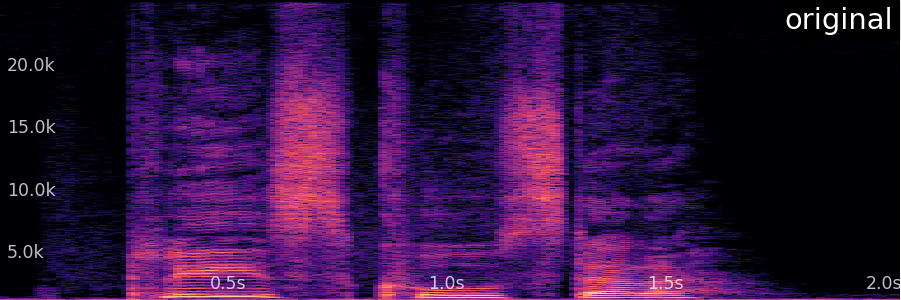
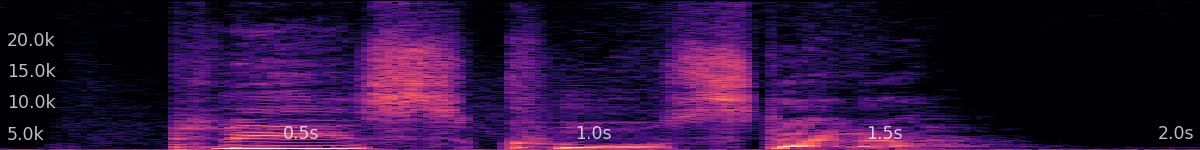

duration: 2.051 seconds
batch_size: 1
path: /tmp/tmpqx757hru.wav
sample_rate: 48000
num_channels: 2
audio_data.shape: torch.Size([1, 2, 98472])
stft_params: STFTParams(window_length=2048, hop_length=512, window_type='hann', match_stride=False, padding_type='reflect')
device: cuda:0




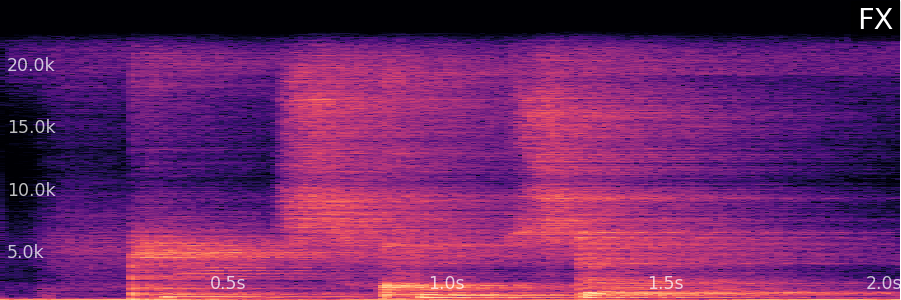
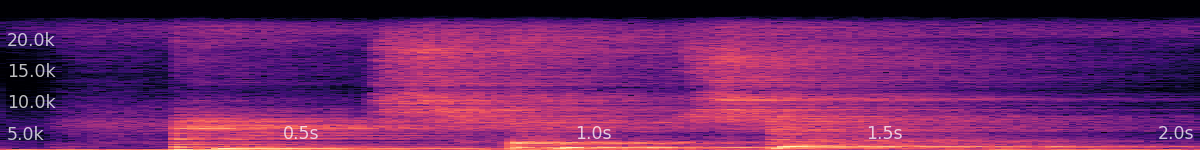

In [7]:
#quick example

channel = Channel(
    # Apply random EQ, Compression, and Gain to a signal
    dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
    dasp_pytorch.Compressor(sample_rate=SAMPLE_RATE),
    dasp_pytorch.Gain(sample_rate=SAMPLE_RATE),
    
    # Apply random Reverb and Distortion to a signal
    Distortion(sample_rate=SAMPLE_RATE),
    dasp_pytorch.NoiseShapedReverb(sample_rate=SAMPLE_RATE),
)

# Let's try to speed up our effects by running on GPU
if torch.cuda.is_available():
    params = torch.randn(signal.batch_size, channel.num_params)
    params_norm = torch.sigmoid(params)
    
    params_norm_cuda = params_norm.clone().cuda()
    signal_cuda = signal.clone().cuda()
    signal.clone().widget('original')
    # signal_cuda.cpu().widget(title='original')
    
    output_cuda = channel(signal_cuda, params_norm_cuda)
    print(output_cuda) 
    output_cuda.cpu().widget(title = 'FX')

else:
    print("CUDA not available on this machine; you'll have to use CPU :(")

Target audio (we want output to sound like this)



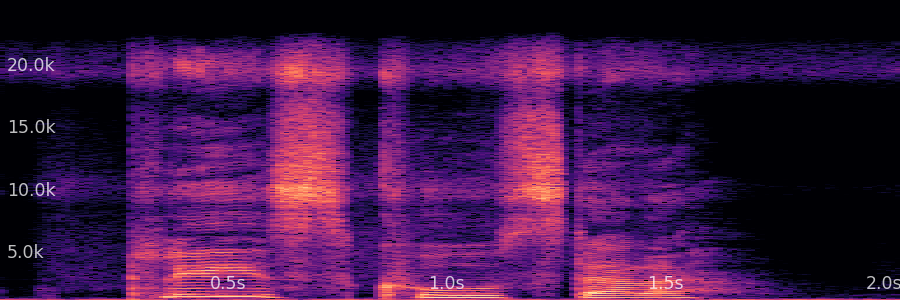
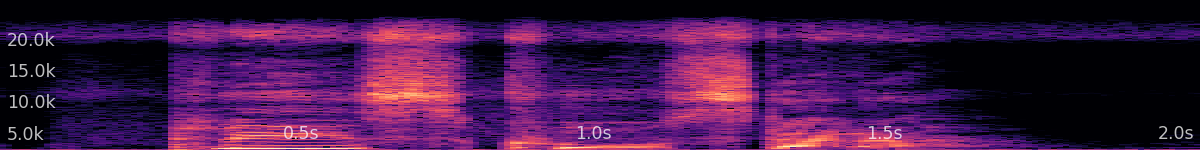

Starting audio -- untrained params, first stage



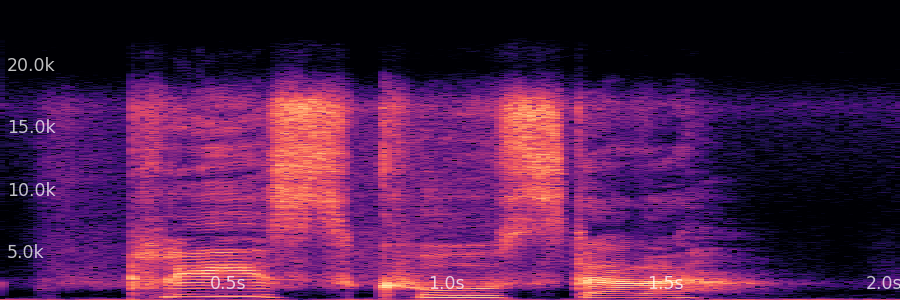
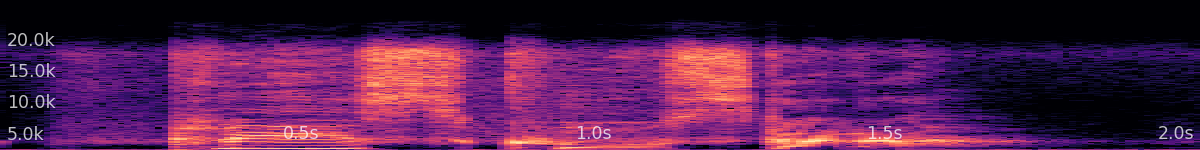

step: 500/500, loss: 0.118: 100%|█| 500/500 [00:31<00:00, 15.63it


Final audio



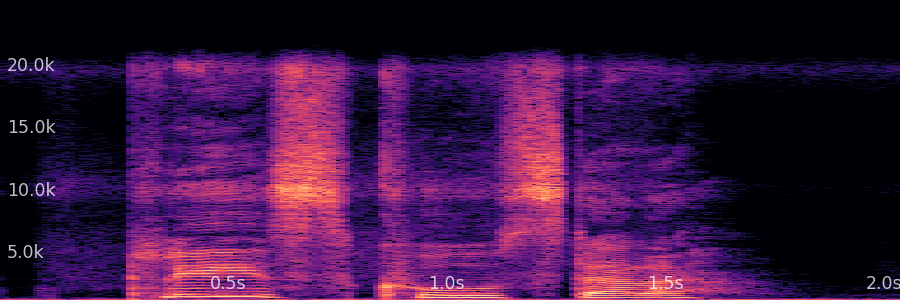
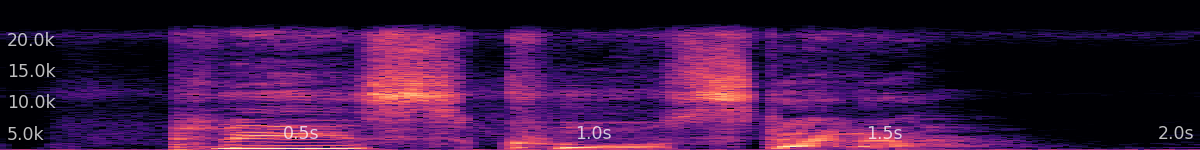

In [8]:
# example parameter extraction
channel = Channel(
    dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
    dasp_pytorch.Compressor(sample_rate=SAMPLE_RATE),
)

# Use GPU if available
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
signal = signal.to(device)

# Initialize random parameters as a "target." Our goal will be to optimize a different set of
# random parameters to match these
params_target = torch.randn(signal.batch_size, channel.num_params).to(device) #roughly [-2, 2] 

# Apply target parameters to get target audio. We will optimize by matching this audio, without any access to
# the target parameters. This mimics the fact that in many real-world scenarios, we won't know the actual 
# target parameters, and will have to estimate them from audio

signal_target = channel(signal.clone().to(device), torch.sigmoid(params_target)).detach() 
#^ autograd -backprop engine, computation graph set of operations tracking gradients, don't track gradients for any of this
# don't often have to use it, but in some cases...

# Initialize our starting parameters
params = torch.nn.parameter.Parameter(torch.randn(signal.batch_size, channel.num_params).to(device))
optimizer = torch.optim.Adam([params], lr=1e-2)

# Play our target and starting audio
print("Target audio (we want output to sound like this)")
signal_target.clone().cpu().widget()
print("Starting audio -- untrained params, first stage")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()

# Optimize our parameters by matching effected audio against the target audio -- AC QUESTION: CONTROLLER?
n_iters = 500
pbar = tqdm(range(n_iters), total=n_iters)
for n in pbar:
    
    # Apply effect with out estimated parameters
    signal_effected = channel(signal, torch.sigmoid(params))

    # Compute distance between estimate and target spectrograms as our loss; in practice,
    # we can use more complicated loss functions to get better results
    loss = torch.nn.functional.mse_loss( #L2
        signal_effected.magnitude, signal_target.magnitude 
        # .magnitude is a (real) property in audiosignal class and computes spectrogram (phase is imaginary component, don't really need it)
        # there are better resolutions/types of spectrograms -- maybe experiment here (e.g. christian -- auraloss)
    )
    # loss = auraloss(signal_effected=resampled.., signal_original=resampled..) <-- what using aura
    # try prem's ? 

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"step: {n+1}/{n_iters}, loss: {loss.item():.3f}")

# Play final signal with optimized effects parameters
print("Final audio")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()
        

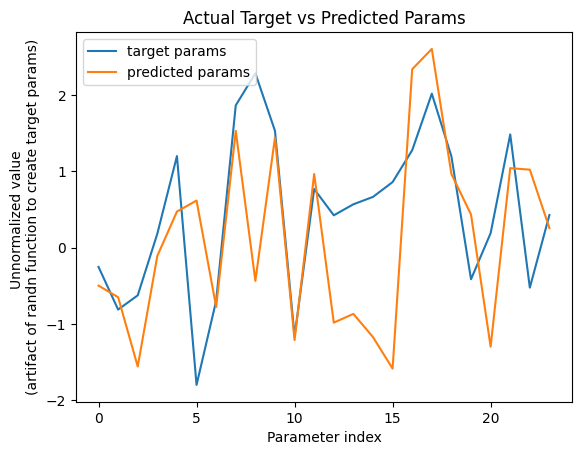

In [9]:
plt.plot(params_target.flatten().cpu().detach(), label="target params")
plt.plot(params.flatten().cpu().detach(), label="predicted params")
plt.ylabel("Unnormalized value \n(artifact of randn function to create target params)") #AC: why is the unnormalized range ~[-2.5, 2.5]? --> just random starting points
plt.xlabel("Parameter index")
plt.title("Actual Target vs Predicted Params")

plt.legend()
plt.show()

#### CLAP

Previously tried LAION edition of CLAP -- seems to not be very good / accurate

Trying new Microsoft CLAP

In [15]:
from msclap import CLAP
import torch.nn.functional as F

# Load model (Choose between versions '2022' or '2023')
# The model weight will be downloaded automatically if `model_fp` is not specified
clap_model = CLAP(version = '2023', use_cuda=True)

#for captioning
clapcap_model = CLAP(version = 'clapcap', use_cuda=True)


In [16]:
# sig = AudioSignal(example_files[5])
# # print(sig)
# print(clap_model.preprocess_audio([str(example_files[5])], resample=True).shape)

# print('')
# sig2 = AudioSignal(example_files[2])
# print(sig2)
# print(clap_model.preprocess_audio([str(example_files[2])], resample=True).shape)


In [17]:
clap_model.args

Namespace(text_model='gpt2', text_len=77, transformer_embed_dim=768, freeze_text_encoder_weights=True, audioenc_name='HTSAT', out_emb=768, sampling_rate=44100, duration=7, fmin=50, fmax=8000, n_fft=1024, hop_size=320, mel_bins=64, window_size=1024, d_proj=1024, temperature=0.003, num_classes=527, batch_size=1024, demo=False)


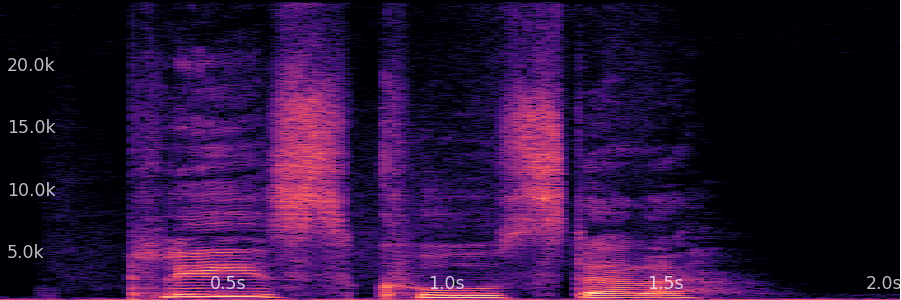
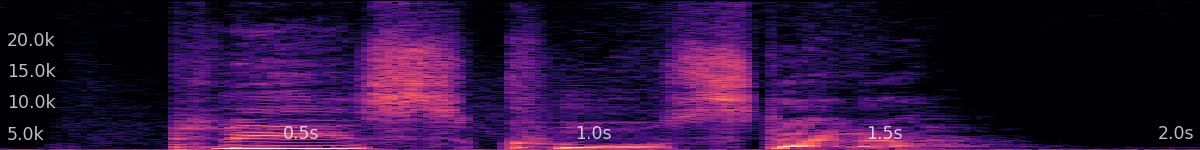

['A man speaks and then pauses. ']


In [18]:
# load audio file
file = example_files[5]
audio_file = [str(file)]

audiosig = AudioSignal(file)
audiosig.widget()

#generate caption
captions = clapcap_model.generate_caption(audio_file)
print(captions)

In [19]:
# Extract text embeddings
target_text = 'a woman talking'
_textOptions = [target_text, 'a man talking', 'a british person talking', 'a british woman talking', 'a dog', 'a cat', 'distorted version of a woman talking']

# Adding in the CLAP generated caption
#_textOptions = [captions[0], target_text, 'a man talking', 'a british person talking', 'a british woman talking', 'a dog', 'a cat', 'distorted version of a woman talking']

_prefix = '' #'this is a sound of ' #<-- they include this in their example, does skew zero-shot predictions
prompts = [_prefix + x for x in _textOptions]

# Load audio files
print(example_files[5])
audio_file = [str(example_files[5])]

text_embeddings = clap_model.get_text_embeddings(prompts)

# Extract audio embeddings
audio_embeddings = clap_model.get_audio_embeddings(audio_file, resample=True)

# Compute similarity between audio and text embeddings 
similarities = clap_model.compute_similarity(audio_embeddings, text_embeddings) #L2 normalized, then cosine similarity (dot prod)

similarity = F.softmax(similarities, dim=1)
values, indices = similarity[0].topk(5)

# Print the results
print("Ground Truth: {}".format(target_text))
print("Top predictions:\n")
for value, index in zip(values, indices):
    # print(f"{_textOptions[index]:>16s}: {100 * value.item():.2f}% ")
    print(f"{_textOptions[index]:<40s}: {100 * value.item():.2f}% (Similarity Score: {similarities[0][index].item():.4f})")


/home/annie/research/text2fx/assets/speech_examples/VCTK_p225_001_mic1.flac
Ground Truth: a woman talking
Top predictions:

a british woman talking                 : 61.41% (Similarity Score: 8.8991)
a british person talking                : 16.87% (Similarity Score: 7.6071)
a woman talking                         : 12.39% (Similarity Score: 7.2983)
distorted version of a woman talking    : 7.40% (Similarity Score: 6.7836)
a man talking                           : 1.93% (Similarity Score: 5.4372)


#### Trying CLAP + dasp

In [20]:
channel = Channel(
    dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
)

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

In [21]:
text_target = 'bright'
embedding_target = clap_model.get_text_embeddings([text_target])

#### Troubleshooting why we're getting different embeddings 

clap_model.get_audio_embeddings(audio_file_path) vs OURS.get_audio_embedding(AudioSignal)

clap_model.get_audio_embeddings(audio_file_path) is comprised of 4 main levels
- clap_model.read_audio(loads audio file and resamples it to be 44.1khz), which is used in ...
- clap_model.load_audio_into_tensor(loads audio file and reworks it to have a duration of 7 seconds), which is used in ...
- clap_model.preprocess_audio(Load list of audio files and return raw audio), which is used in ...
- clap_model._get_audio_embeddings(Load preprocessed audio and returnsaudio embeddings)

After unfolding all levels, it seems like the root cause is at the LOAD audio file part in .read_audio, where torchaudio.load(audio_path) in .read_audio =/= how AudioSignal(audio_file) is reading things in


In [42]:
"""
NOT WORKING: TRYING TO REPLICATE THE clap_model.get_audio_embedding(audio_file_path) --> newfunc_get_audio_embedding(AudioSignal)
"""
# audio_file = example_files[5]
# audio_file_clap = [str(audio_file)] #for clap_model.get_audio_embedding(audio_file_clap)

# signal = AudioSignal(audio_file) #for input to preprocess_sig(signal)
# print(signal)

def ms_clap_audio_trim(audio_time_series, audio_duration, sample_rate):
    audio_time_series = audio_time_series.squeeze(0).squeeze(0)
    if audio_duration*sample_rate >= audio_time_series.shape[0]: #if audio duration is shorter than 7 seconds, repeat samples
        repeat_factor = int(np.ceil((audio_duration*sample_rate) /
                                    audio_time_series.shape[0]))
        # Repeat audio_time_series by repeat_factor to match audio_duration
        audio_time_series = audio_time_series.repeat(repeat_factor)
        # remove excess part of audio_time_series
        audio_time_series = audio_time_series[0:audio_duration*sample_rate]
    else:
        # audio_time_series is longer than predefined audio duration (7s),
        # so audio_time_series is trimmed
        start_index = random.randrange(
            audio_time_series.shape[0] - audio_duration*sample_rate)
        audio_time_series = audio_time_series[start_index:start_index +
                                              audio_duration*sample_rate]
    return torch.FloatTensor(audio_time_series.unsqueeze(0).unsqueeze(0))

# SHOULD BE equivalent to clap_model.preprocess_audio()
#for a single sample, can adapt for batch
def preprocess_sig(signal: AudioSignal):
    #these three are equivalent to .load_audio_into_tensor()
    signal.resample(clap_model.args.sampling_rate)
    # print(signal.samples)
    signal.to_mono()
    # print(signal.samples.shape)

    #this is what clap_model.preprocess_audio() does
    signal.samples = ms_clap_audio_trim(signal.samples, clap_model.args.duration, clap_model.args.sampling_rate) #bottleneck - only single sample

    return signal

#testing just the clap_model.load_audio() !!
def testingsampler(signal: AudioSignal, resample=True):
    """
    trying to see if resampling step in read_audio (step 1) is the issue, but it seems its from the very beginning w/ reading in the file
    """
    audio_time_series = signal.samples
    print(f'before {signal.samples}')
    resample_rate = clap_model.args.sampling_rate
    sample_rate = signal.sample_rate #check

    print(resample_rate, sample_rate) #sample rate is the same, not even hitting the resampling stage
    if resample and resample_rate != sample_rate:
        resampler = T.Resample(sample_rate, resample_rate)
        audio_time_series = resampler(audio_time_series)
        signal.samples = audio_time_series
        print(f'after {signal.samples}')
        
    return signal


In [45]:
#checking if resampling stage is affecting things, but sample rates are the same

audio_file = example_files[5]
audio_file_clap = str(audio_file)

clap_signal1 = clap_model.read_audio(audio_file_clap) #uses CLAP function on torchaudio.load(audio_path)
print(clap_signal1[0])

signal = AudioSignal(audio_file)
signal1 = signal.resample(clap_model.args.sampling_rate) #uses built-in AudioSignal.resample function
print(signal1.samples)

signal2 = testingsampler(signal) #uses CLAP function on AudioSignal.samples
print(signal2.samples)

tensor([[0.0048, 0.0069, 0.0063,  ..., 0.0082, 0.0089, 0.0009]])
tensor([[[0.0051, 0.0067, 0.0064,  ..., 0.0080, 0.0084, 0.0085]]])
before tensor([[[0.0051, 0.0067, 0.0064,  ..., 0.0080, 0.0084, 0.0085]]])
44100 44100
tensor([[[0.0051, 0.0067, 0.0064,  ..., 0.0080, 0.0084, 0.0085]]])


In [ ]:

#choosing an audio file
audio_file = example_files[5]

# 1: CLAP style
   ## Full wrapper --> input: raw file, output: embedding
audio_file_clap = [str(audio_file)]
emb1 = clap_model.get_audio_embeddings(audio_file_clap)

   ## Semi-full wrapper --> input y (should be raw audio samples), output: embedding
y = clap_model.preprocess_audio(audio_file_clap, resample=True)
emb1a = clap_model._get_audio_embeddings(y)

#2 : measuring own function
signal = AudioSignal(audio_file)
x2 = preprocess_sig(signal) #SHOULD EQUAL OUTPUT OF clap_model.preprocess_audio, but it doesn't!!
emb2 = clap_model._get_audio_embeddings(x2.samples.to('cuda'))


# OK SO THESE ARE DIFFERENT=====
# print(y)
print(x2.samples)

# print(emb1[:5])
# print(emb1a[:5])
# print(emb2[:5])

#### TODO : DASP + CLAP

In [ ]:
# Initialize our starting parameters
params = torch.nn.parameter.Parameter(torch.randn(signal.batch_size, channel.num_params).to(device))
optimizer = torch.optim.Adam([params], lr=1e-2)

# Play our starting audio
print("Starting audio - applied untrained parameters of just channel of just EQ ")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()

# Optimize our parameters by matching effected audio against the target audio
n_iters = 500
pbar = tqdm(range(n_iters), total=n_iters)
for n in pbar:
    
    # Apply effect with out estimated parameters
    # signal_effected = channel(signal, torch.sigmoid(params))
    signal_effected = channel(signal.to(device), torch.sigmoid(params.to(device)))

    #TODO: convert signal_effected back to audio file? 
    # x_signal_effected = signal_effected.audio_data.mean(1)

    # Get CLAP embedding for effected audio
    embedding_effected = clap_model._get_audio_embeddings(x_signal_effected) #.get_audio_embeddings takes in preprocessed audio

    # Compute distance between our effected audio embedding vector and the target text 
    # embedding vector. We use cosine distance (essentially the negative dot product
    # between vectors). When two vectors are "aligned" (pointing in the same direction), 
    # their dot product will be high. We thus penalize a small dot product to try to
    # bring our audio vector "into alignment" with the text vector.
    loss = -(embedding_effected @ embedding_target.T).sum()

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"step: {n+1}/{n_iters}, loss: {loss.item():.3f}")

# Play final signal with optimized effects parameters
print("Final audio")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()

In [ ]:
#scrap from old clap
channel = Channel(
    dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
)

# Use GPU if available
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
signal = signal.to(device)
model = model.to(device)

# Our target is a CLAP embedding, and we'll perform matching in the embedding space rather than 
# the audio space
text_target = "bright"
embedding_target = clap_embed_text(text_target, model).detach()

# Initialize our starting parameters
params = torch.nn.parameter.Parameter(torch.randn(signal.batch_size, channel.num_params).to(device))
optimizer = torch.optim.Adam([params], lr=1e-2)

# Play our starting audio
print("Starting audio - applied untrained parameters of just channel of just EQ ")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()

# Optimize our parameters by matching effected audio against the target audio
n_iters = 500
pbar = tqdm(range(n_iters), total=n_iters)
for n in pbar:
    
    # Apply effect with out estimated parameters
    signal_effected = channel(signal, torch.sigmoid(params))

    # Get CLAP embedding for effected audio
    embedding_effected = clap_embed_audio(signal_effected, model, quantize=False)

    # Compute distance between our effected audio embedding vector and the target text 
    # embedding vector. We use cosine distance (essentially the negative dot product
    # between vectors). When two vectors are "aligned" (pointing in the same direction), 
    # their dot product will be high. We thus penalize a small dot product to try to
    # bring our audio vector "into alignment" with the text vector.
    loss = -(embedding_effected @ embedding_target.T).sum()

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"step: {n+1}/{n_iters}, loss: {loss.item():.3f}")

# Play final signal with optimized effects parameters
print("Final audio")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()